Import required libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GroupKFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt

Block of primary analysis

In [2]:
# Loading the training dataset. Checking the dimension
train = pd.read_csv('datasets/bike_train.csv')
train.shape

(10886, 12)

In [3]:
# We look at general information on features (types)
# No data gaps
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# Seeing multiple rows in data
train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
6638,2012-03-13 21:00:00,1,0,1,1,23.78,27.275,56,7.0015,44,200,244
7975,2012-06-12 16:00:00,2,0,1,2,27.06,29.545,89,19.0012,30,209,239
5915,2012-02-02 16:00:00,1,0,1,1,18.86,22.725,55,19.0012,18,211,229
8050,2012-06-15 19:00:00,2,0,1,1,28.70,31.820,42,11.0014,98,369,467
5894,2012-02-01 19:00:00,1,0,1,1,22.14,25.760,52,19.0012,20,315,335


In [5]:
# Target variable - count
# It consists of casual and registered
# registered - this is a registered lease
# casual - random, you can say someone came from the street and took the bike

# Checking. Should be zero
train[train['casual'] + train['registered'] != train['count']].shape

(0, 12)

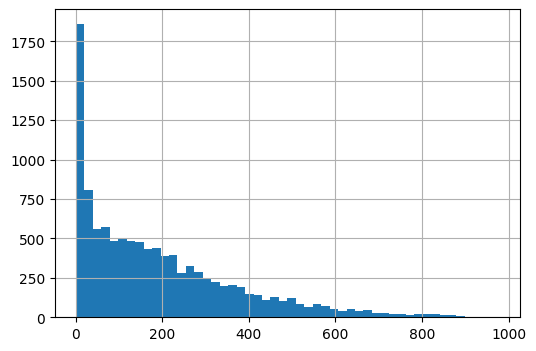

In [6]:
# We look at the distribution of the target variable. Histogram tail is skewed to the right
# It will be necessary to transform the target feature (make a logarithm) to simplify the model
plt.rcParams['figure.figsize']=(6,4)
train['count'].hist(bins=50);

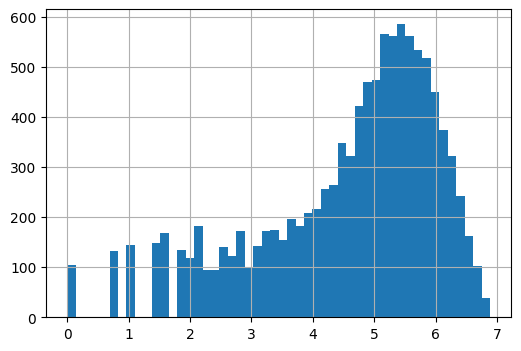

In [7]:
# Target feature, only with logarithmization. The sign began to look more uniform
np.log(train['count']).hist(bins=50);

Block of modeling and creation of new features

Feature Engineering #1

In [8]:
# We decompose the datetime attribute into separate elements. (year, month, day, etc.)
train['datetime'] = pd.to_datetime(train['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute

train['dayofweek'] = train['datetime'].dt.dayofweek
train['weekofyear'] = train['datetime'].dt.isocalendar().week
train['weekend'] = train['dayofweek'].map(lambda x: int(x in [5,6]))
train['dayofyear'] = train['datetime'].dt.dayofyear

In [9]:
# A function that returns numerical features for training the model
def get_feats(df):
	black_list = ['count', 'count_log', 'registered', 'registered_log', 'casual', 'casual_log']
	feats = df.select_dtypes(include=[np.number]).columns
	feats = [feat for feat in feats if feat not in black_list]
	return feats

# Feature separation function related to time so that there is a uniform distribution
def custom_validation(df, feats, target_variable='count', n_folds=3):
	X = df[feats].values
	y = df[target_variable].values

	groups = train['month'].values
	group_kfold = GroupKFold(n_splits=n_folds)

	for train_idx, test_idx in group_kfold.split(X, y, groups):
		yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Model training function
def run_cv(train, feats, model, folds=3):
	scores = []
	for X_train, X_test, y_train, y_test in custom_validation(train, feats):
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)
		score = np.sqrt(mean_squared_log_error(y_test, y_pred))

		scores.append(score)

	return np.mean(scores), np.std(scores)

In [10]:
# Train the DecisionTreeRegressor Model
# We get approximately 0.62
run_cv(train, get_feats(train), DecisionTreeRegressor(max_depth=5, random_state=0))

(0.6246871988174122, 0.0043396585185402)

In [11]:
# Run the RandomForestRegressor model
# The result has become better - 0.60
run_cv(train, get_feats(train), RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0))

(0.60536168716467, 0.006459069185653864)

Feature Engineering #2

In [12]:
# We continue to work with features
# Let's group by year
agg_feats = ['year', 'hour']
agg_func = np.median

agg_hour_year = train[agg_feats + ['count']].groupby(agg_feats).agg(agg_func).to_dict()['count']
new_feat = '{0}_{1}'.format(agg_func.__name__, '_'.join(agg_feats))
train[agg_feats].apply(lambda x: agg_hour_year[tuple(dict(x).values())], axis=1).head()

0    32.0
1    16.0
2    10.0
3     6.0
4     5.0
dtype: float64

In [13]:
# Let's aggregate 2 variables. Calculate mean time, median, and standard deviation
agg_feats = [
	['hour', 'year'],
	['hour', 'season'],
	['hour', 'month']
]

for agg_feat in tqdm(agg_feats):
	for agg_func in [np.mean, np.median, np.sum, np.std]:
		dict_agg = train[agg_feat + ['count']].groupby(agg_feat).agg(agg_func).to_dict()['count']
		new_feat = 'agg_{0}_{1}'.format(agg_func.__name__, '_'.join(agg_feat)) 

		default_dict_val = agg_func(list(dict_agg.values()))
		default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

		train[new_feat] = train[agg_feat].apply(lambda x: dict_agg[tuple(dict(x).values())], axis=1)

100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


In [14]:
# List of resulting additional features
agg_feats = [feat for feat in train.columns if feat.startswith('agg_')]
agg_feats

['agg_mean_hour_year',
 'agg_median_hour_year',
 'agg_sum_hour_year',
 'agg_std_hour_year',
 'agg_mean_hour_season',
 'agg_median_hour_season',
 'agg_sum_hour_season',
 'agg_std_hour_season',
 'agg_mean_hour_month',
 'agg_median_hour_month',
 'agg_sum_hour_month',
 'agg_std_hour_month']

In [15]:
# Checking out the new RandomForestRegressor model
# The result is about the same, even became a little worse
run_cv(train, get_feats(train), RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0))

(0.6124358467194936, 0.022378367970889525)

In [16]:
# Perform a logarithmic transformation of the target variable (count)
# For symmetry, add a constant value in front of the logarithm
feats = get_feats(train)
X = train[feats].values

groups = train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)

count = train['count'].values
offset_log = 6
count_log = np.log2(count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):
    model = DecisionTreeRegressor(max_depth=5, random_state=0)
    model.fit(X[train_idx], count_log[train_idx])
    count_log_pred = model.predict(X[test_idx])
    
    count_pred = np.exp2( count_log_pred ) - offset_log
    score = np.sqrt(mean_squared_log_error(count[test_idx], count_pred))
    scores.append(score)

np.mean(scores), np.std(scores)
# Model result improved - 0.585

(0.5856258021778558, 0.02033189692720682)

In [17]:
# Let's do the same conversion for registered, casual (since they affect count)
feats = get_feats(train)
groups = train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
X = train[feats].values
offset_log = 3

registered = train['registered'].values
registered_log = np.log2(registered + offset_log)

casual = train['casual'].values
casual_log = np.log2(casual + offset_log)

count = train['count'].values
count_log = np.log2(count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):
	model = DecisionTreeRegressor(max_depth=5, random_state=2019)
	model.fit(X[train_idx], registered_log[train_idx])
	registered_log_pred = model.predict(X[test_idx])
	registered_pred = np.exp2(registered_log_pred) - offset_log

	model = DecisionTreeRegressor(max_depth=5)
	model.fit(X[train_idx], casual_log[train_idx])
	casual_log_pred = model.predict(X[test_idx])
	casual_pred = np.exp2(casual_log_pred) - offset_log

	count_pred = registered_pred + casual_pred
	score = np.sqrt(mean_squared_log_error(count[test_idx], count_pred))
	scores.append(score)

np.mean(scores), np.std(scores)
# The result is even better - 0.56

(0.5619351616859883, 0.01840269129197027)

In [18]:
# Итоговая функция для моделирования
def run_log_registered_casual(train, model_class, model_params={}, feats=None, folds=3):
	if feats is None:
		feats = get_feats(train)

	groups = train['datetime'].dt.month.values
	group_kfold = GroupKFold(n_splits=3)

	X = train[feats].values
	offset_log = 3

	registered = train['registered'].values
	registered_log = np.log2(registered + offset_log)

	casual = train['casual'].values
	casual_log = np.log2(casual + offset_log)

	count = train['count'].values
	count_log = np.log2(count + offset_log)

	scores = []
	for train_idx, test_idx in group_kfold.split(X, count, groups):
		model = model_class(**model_params)
		model.fit(X[train_idx], registered_log[train_idx])
		registered_log_pred = model.predict(X[test_idx])
		registered_pred = np.exp2(registered_log_pred) - offset_log

		model = model_class(**model_params)
		model.fit(X[train_idx], casual_log[train_idx])
		casual_log_pred = model.predict(X[test_idx])
		casual_pred = np.exp2(casual_log_pred) - offset_log

		count_pred = registered_pred + casual_pred

		score = np.sqrt(mean_squared_log_error(count[test_idx], count_pred))
		scores.append(score)

	return np.mean(scores), np.std(scores)

In [19]:
# Train the RandomForestRegressor Model
# Based on this dataset, we trained models that showed approximately 0.356 error from the desired values

rf_params = {
    'n_estimators': 100, 
    'max_depth': 15, 
    'random_state': 0, 
    'min_samples_split' : 5
}
run_log_registered_casual(train, RandomForestRegressor, rf_params )

(0.3566502685231591, 0.007714002957999988)